In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import Counter
import os
from tqdm import tqdm
import json
import random
from scipy.special import softmax
import sklearn
import torch
import shutil
import glob
from sklearn import model_selection
# trainList, testList = model_selection.train_test_split(imgPath,test_size=0.3)
import skimage
import scipy.ndimage as ndi
from skimage import measure,color,morphology
import onnxruntime

 ## tools

In [3]:
## tool functions
# cv2中文路径(windows)
def cv2_imgread(path, flag=1):
    img = cv2.imdecode(np.fromfile(path, dtype=np.uint8), flag)
    return img
def cv2_imgwrite(img, path, img_format = ".png"):
    cv2.imencode(img_format, img)[1].tofile(path)

def file_list(path):
    """
    遍历生成path下所有文件的绝对路径
    """
    abspath = []
    for filepath,dirnames,filenames in os.walk(path):
        for filename in filenames:
            abspath.append(os.path.join(filepath, filename))
    return abspath

def get_mask_from_json(json_path, category_map, multihot=False):
    """
    标注json转mask
    category_map：[["defect1"],["defect21", "defect22"]]
    注意json中出现的标注名如果未出现再在category_map中被认定为BG
    """

    with open(json_path, 'r') as r:
        anno = json.loads(r.read())
    inform = anno['shapes']
    height = anno['imageHeight']
    width = anno['imageWidth']
    if multihot:
        res_mask = []
        for k in range(1, len(category_map)):
            mask = np.zeros((height, width), dtype=np.uint8)
            for i in inform:
                label_id = i['label']
                points = i['points']
                if label_id in category_map[k]:
                    cv2.polylines(mask, np.array([points], dtype=np.int32),
                                  True, 1)
                    cv2.fillPoly(mask, np.array([points], dtype=np.int32), 1)
            res_mask.append(np.expand_dims(mask, 2))
        mask = np.concatenate(res_mask, axis=2)
    else:
        mask = np.zeros((height, width), dtype=np.uint8)
        for i in inform:
            label_id = i['label']
            points = i['points']
            for id_, id_category_list in enumerate(category_map):
                if label_id in id_category_list:
                    cv2.polylines(mask, np.array([points], dtype=np.int32),
                                    True, id_)
                    cv2.fillPoly(mask, np.array([points], dtype=np.int32), id_)
                    break
            else:
                print(
                    "{} doesn't exist in category map, "
                    'set it as BG by default.'.format(label_id))
    return mask

def gen_mask(in_mask, num_class, color_map=[]):
    """
    可视化mask
    in_mask：0, 1, 2....分类代表不同类别
    """
    mask = np.zeros((in_mask.shape[0], in_mask.shape[1], 3), dtype=np.uint8)
    assert num_class == len(color_map)
    for i in range(num_class):
        mask[np.where(in_mask == i)[0],
                np.where(in_mask == i)[1], :] = color_map[i]
    return mask

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(20, 15))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

def check_connect_comp(img, label_index):
    mask = np.array(img == label_index, np.uint8)
    num, label = cv2.connectedComponents(mask, 8)
    return mask, num, label

def sdk_post(predict_score, img, cfg):
    num_class = cfg['num_classes']
    _mask = np.argmax(softmax(predict_score, 0), 0)
    predict = np.zeros(_mask.shape)
    ori_img_mask = np.zeros(img.shape)
    thre = cfg['thre']
    assert num_class == len(thre)
    for i in range(num_class):
        if i == 0:
            continue
        else:
            _, num, labels = check_connect_comp(_mask, i)
            for j in range(num):
                if j == 0:
                    continue
                else:
                    temp = np.array(labels == j)
                    area = np.sum(temp > 0)
                    print(cfg['label_map'][i], area)
                    if area > thre[i]:
                        predict += temp * i
                        ori_img_patch = np.repeat(temp[:, :, np.newaxis], 3, axis=2)
                        print('mean', np.mean(img[temp], axis=0))
                        ori_img_mask += img.copy()*ori_img_patch
    return ori_img_mask, predict

## 生成datalist

In [6]:
txtPath = "/data/home/sharedir/industrial/wn/industrial/MEIS/1008_测试数据//data.txt"
with open(txtPath, "w") as f:
    for i in glob.glob("/data/home/sharedir/industrial/wn/industrial/MEIS/1008_测试数据/Body_Chipping/camera3/*"):
        line = i[5:]
        # new = "/".join(i.split('/')[:-2])
        # line = i + "," + new + "/labels/" + i.split('/')[-1][:-3] + 'json' 
        f.write(line+"\n")

In [3]:
category_map=[['bg'],['yinxian'],['yinxianniujie'],["jiaocha"],["yiwu"]]
json_path = "/data/home/nanwang/data/haojida/20210819/color_img/皓吉达样本/线扭曲/Image_20210814110510132.json"
mask = get_mask_from_json(json_path=json_path, category_map=category_map, multihot=True)
mask.shape

(3000, 4096, 4)

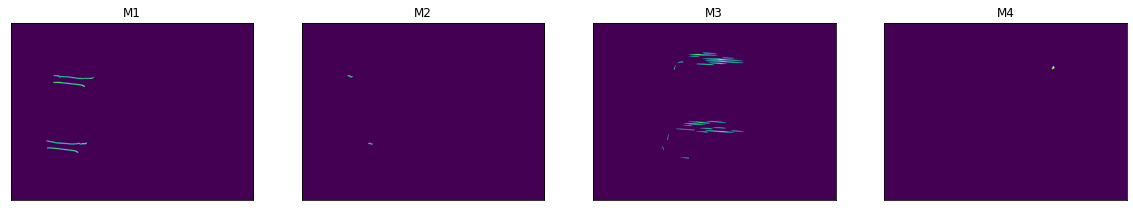

In [4]:
visualize(m1=mask[:,:,0], m2=mask[:,:,1],m3=mask[:,:,2],m4=mask[:,:,3])

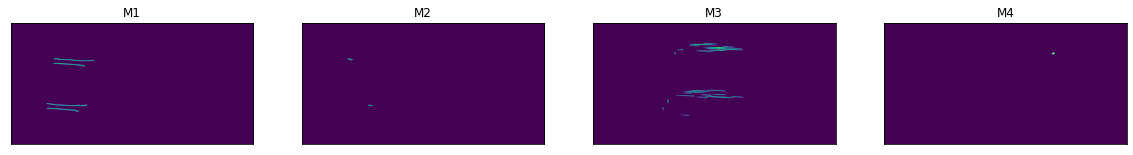

In [5]:
resize_mask = cv2.resize(mask,dsize=(2000, 1000),interpolation=cv2.INTER_NEAREST)
visualize(m1=resize_mask[:,:,0], m2=resize_mask[:,:,1],m3=resize_mask[:,:,2],m4=resize_mask[:,:,3])

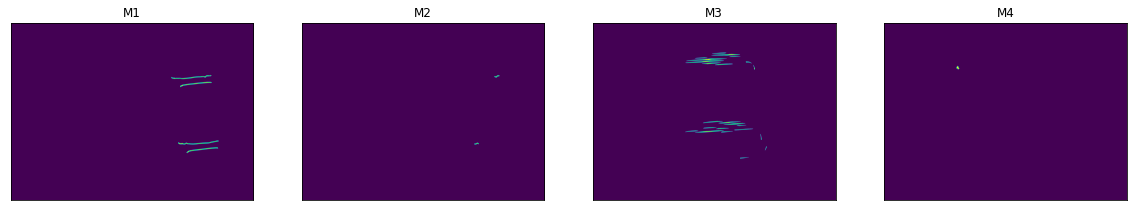

In [6]:
flip_mask = cv2.flip(mask,1)
visualize(m1=flip_mask[:,:,0], m2=flip_mask[:,:,1],m3=flip_mask[:,:,2],m4=flip_mask[:,:,3])

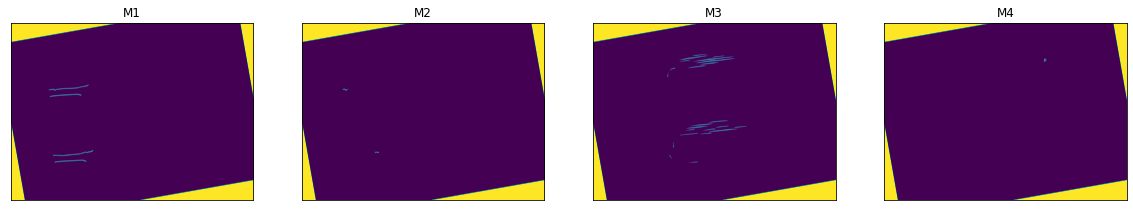

In [14]:
h, w, c = mask.shape[0], mask.shape[1], mask.shape[2]
matrix = cv2.getRotationMatrix2D((w / 2, h / 2), 10, 1)
rot_img = cv2.warpAffine(mask,
            matrix, (w, h),
            flags=cv2.INTER_NEAREST,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=[255]*c)
rot_img[rot_img==1]=125
visualize(m1=rot_img[:,:,0], m2=rot_img[:,:,1],m3=rot_img[:,:,2],m4=rot_img[:,:,3])

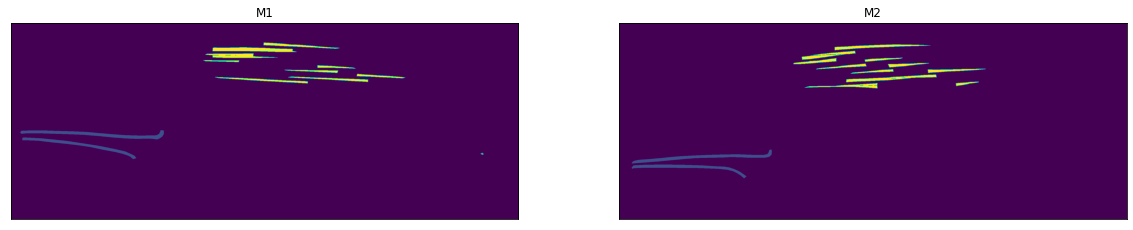

In [22]:
mask1 = cv2.imread("/data/home/nanwang/data/haojida/20210819/color_img_refine_label/皓吉达样本_标注(修改)_crop/点胶不良/dianjiaogao(wufajian)_0.png", 0)
mask2 = cv2.imread("/data/home/nanwang/data/haojida/20210819/color_img_refine_label/皓吉达样本_标注(修改)_crop/点胶不良/diaojiaobuquan_0.png", 0)
visualize(m1=mask1, m2=mask2)

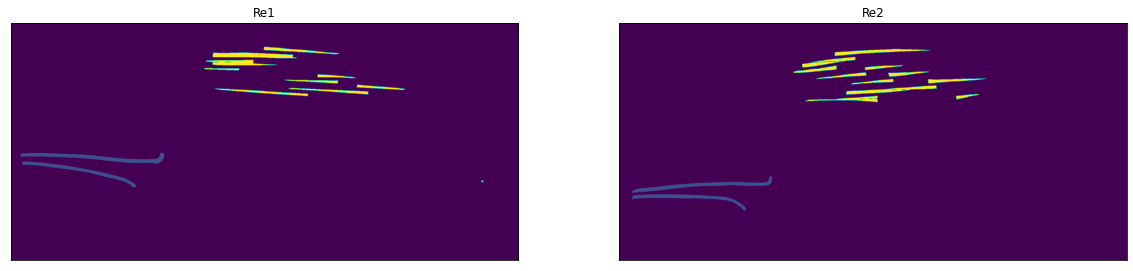

In [23]:
stack_mask = np.stack((mask1,mask2), axis=2)
resize_mask = cv2.resize(stack_mask,dsize=(2048, 960),interpolation=cv2.INTER_NEAREST)
visualize(re1=resize_mask[:,:,0], re2=resize_mask[:,:,1])

In [ ]:
## 把test里面所有含有长度>20的图都找出来,存在test_threshold里
threshold = 20
testtxt = "/data/home/sharedir/industrial/wn/industrial/MEIS/20210714/20210716_datalist/test.txt"
test_threshold = set()
root = "/data/home/sharedir/industrial/wn/industrial/MEIS/20210714/SOD523_alllead/"
root = "/data"
category_map = [["bg"],["lead", 'eq']]
with open(testtxt, "r") as f:
    for i in f.readlines():
        i = i.strip().split(",")[-1]
        json_path = root + i
        image_path= root + i[:-4] + "bmp"
        if os.path.exists(json_path):
            mask = get_mask_from_json(json_path, category_map)
        else:
            continue
        contours, hierarchy = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
        for i in range(len(contours)):
            _, _, _, height = cv2.boundingRect(contours[i])
            if height > threshold:
                tmp = image_path.split("/")
                test_threshold.add(tmp[-3]+"/"+tmp[-2]+"/"+tmp[-1])
                break
        

In [ ]:
len(test_threshold)

In [ ]:
## 网络预测的ng结果
txtpath = "/data/home/nanwang/industrial/poc/MEIS/Nolead/20210714/inference_res/16000.onnx/ng_result.txt"
ngset = set()
with open(txtpath, "r") as f:
    for i in f.readlines():
        imagename = i.strip().split("/")[-1]
        camera    = i.strip().split("/")[-2]
        filename  = i.strip().split("/")[0]
        if filename == "WDPA12058F00_02":
            ngset.add(i.strip())

In [ ]:
nglist_path = "/data/home/sharedir/industrial/wn/industrial/MEIS/20210703/WDPA12058F00_02/ngdata.txt"
ng_gt_set = set()
with open(nglist_path, "r") as f:
    for i in f.readlines():
        tmp = i.strip().split("/")
        imagename = tmp[-1]
        camera    = tmp[-2]
        filename  = tmp[-4]
        ng_gt_set.add(filename+"/"+camera+"/"+imagename)
        

In [ ]:
# ng_gt_set = test_threshold
len(ngset & ng_gt_set)

In [ ]:
# 漏检
((sorted(ng_gt_set - ngset)))

In [ ]:
# 过杀
(sorted(ngset - ng_gt_set))

## onnx及后处理代码

In [ ]:
class ONNX_Model():
    def __init__(self, onnx_path):
        self.onnx_session = onnxruntime.InferenceSession(onnx_path)

    def __call__(self, x):
        onnx_predict = self.onnx_session.run(None,
                                             {'input': x.astype(np.float32)})
        # post-process
        predict_score = onnx_predict[0][0]
        predict = np.argmax(predict_score, 0)
        return predict

def preprocess(img_path):
    mean = [123.675, 116.28, 103.53]
    std = [58.395, 57.12, 57.375]
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # 切图方式需定义化
    if image.shape[0] == 1178:
        image = image[250:930, 220:900, :]
    elif image.shape[0] == 1328:
        image = image[320:1000, 210:890, :]
    elif image.shape[0] == 692:
        image = image[0:680, 65:745, :]
    else:
        get_root_logger().error("{} doesn't exist.".format(img_path))
        raise FileNotFoundError(img_path) 
    image = cv2.resize(image, dsize=(680,680))
    ori_img = image.copy()
    image = image.astype(np.float32)
    image -= np.float32(mean)
    image /= np.float32(std)
    image = image[np.newaxis, :, :, :]
    image = np.transpose(image, [0, 3, 1, 2])
    return image, ori_img

In [ ]:
['0716/Camera3/641.bmp',
 '0716/Camera3/6423.bmp',
 '0716/Camera3/6510.bmp',
 '0716/Camera3/910.bmp',
 '0716/Camera5/425.bmp',
 '0716/Camera5/471.bmp',
 '0716/Camera5/494.bmp',
 'WDPA25076800_02/Camera7/8211.bmp']

In [ ]:
threshold = 20
onnx_path='/data/home/nanwang/industrial/poc/MEIS/lead/20210716/0715_hpo_setting/deploy/12000.onnx'
imglists = ["/data/home/sharedir/industrial/wn/industrial/MEIS/20210714/0716/Camera3/641.bmp",
"/data/home/sharedir/industrial/wn/industrial/MEIS/20210714/0716/Camera3/6423.bmp",
"/data/home/sharedir/industrial/wn/industrial/MEIS/20210714/0716/Camera3/6510.bmp",
"/data/home/sharedir/industrial/wn/industrial/MEIS/20210714/0716/Camera3/910.bmp",
"/data/home/sharedir/industrial/wn/industrial/MEIS/20210714/0716/Camera5/425.bmp",
"/data/home/sharedir/industrial/wn/industrial/MEIS/20210714/0716/Camera5/471.bmp",
"/data/home/sharedir/industrial/wn/industrial/MEIS/20210714/0716/Camera5/494.bmp",
"/data/home/sharedir/industrial/wn/industrial/MEIS/20210714/SOD523_alllead/WDPA25076800_02/Camera7/8211.bmp"]

##漏杀的几张
# imglists = ['0716/Camera3/1091.bmp',
#  '0716/Camera3/753.bmp',
#  '0716/Camera5/458.bmp',
#  '0716/Camera5/600.bmp',
#  '0716/Camera9/728.bmp']
# imglists = ["/data/home/sharedir/industrial/wn/industrial/MEIS/20210714/"+i for i in imglists]
##

onnx_model = ONNX_Model(onnx_path)


In [ ]:
pbar = tqdm(total=len(imglists))
lousha_maxheight = []
for eachlist in imglists:
    imgName = eachlist.split('/')[-1]
    CameraName = eachlist.split('/')[-2]
    fileName = eachlist.split('/')[-3]

    image, ori_image = preprocess(eachlist)
    pre = onnx_model(image)
    output = pre.astype(np.uint8)
    img_remove = output
    mask = np.zeros((img_remove.shape[0], img_remove.shape[1], 3), dtype=np.uint8)
    mask[np.where(img_remove == 1)[0], np.where(img_remove == 1)[1], :] = [0,255,0]
    gt_img = cv2.addWeighted(ori_image, 0.6, mask, 0.4, 0)
    debug_graph = np.concatenate([ori_image, gt_img], axis=1)
    dstPath = "/data/home/nanwang/industrial/poc/MEIS/lead/20210716/0715_hpo_setting/inference_res/12000.onnx/overkill"
    cv2.imwrite(os.path.join(dstPath, imgName[:-4] + '.jpg'), debug_graph)
    pbar.update(1)
    ## 把含有height大于threshold的都找出来
    contours, hierarchy = cv2.findContours(output, mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
    max_height = 0
    for i in range(len(contours)):
        _, _, _, height = cv2.boundingRect(contours[i])
        max_height = max(height, max_height)
    lousha_maxheight.append(max_height)

In [ ]:
lousha_maxheight

In [ ]:
category_map = [["bg"],["lead", 'eq']]
gt_maxheight = []
for i in imglists:
    i = i.strip().split(",")[-1]
    image_path = i
    json_path  = i[:-4] + ".json"
    if os.path.exists(json_path):
        mask = get_mask_from_json(json_path, category_map)
    else:
        continue
    contours, hierarchy = cv2.findContours(mask, mode=cv2.RETR_EXTERNAL,method=cv2.CHAIN_APPROX_NONE)
    max_height = 0
    for i in range(len(contours)):
        _, _, _, height = cv2.boundingRect(contours[i])
        max_height = max(height, max_height)
    gt_maxheight.append(max_height)

In [ ]:
gt_maxheight

## 可视化标注Mask（如果想crop不好改）

In [ ]:
class MaskPainter():
    def __init__(self, num_classes, label_map, color_map=None, category_map=None , mask_weight=0.5, labelme=True):
        # labelme=True则是labelme格式，必须给出category_map -> List；
        # num_classes类别数；
        # label_map -> List, 类名，长度和num_classes一致；
        # color_map -> List, 显示颜色定义；
        self.num_classes = num_classes
        self.color_map =  self.random_color() if not color_map else color_map
        if self.color_map is None or len(self.color_map) != self.num_classes:
            self.color_map = self.random_color()
        self.label_map = label_map
        self.mask_weight = mask_weight
        self.labelme = labelme
        if self.labelme:
            assert category_map
        self.category_map = category_map
    def random_color(self):
        color_map = []
        for i in range(0, self.num_classes):
            color_map.append((random.randint(0, 255), random.randint(0, 255),
                              random.randint(0, 255)))
        return color_map
        
    def gen_mask(self, segm):
        mask = np.zeros((segm.shape[0], segm.shape[1], 3), dtype=np.uint8)
        for i in range(0, self.num_classes):
            mask[np.where(segm == i)[0],
                 np.where(segm == i)[1], :] = self.color_map[i]
        return mask

    # 传入image路径和对应label的路径
    def run(self, img_path, gt_path):
        img = cv2_imgread(img_path)
        if self.labelme:
            gt = get_mask_from_json(gt_path, self.category_map)
        else:
            gt= cv2_imgread(gt_path, 0)
        gt_mask = self.gen_mask(gt)
        if img.shape[-1] == 1:
            img_ = np.concatenate([img, img], 2)
            img = np.concatenate([img_, img], 2)
        gt_img = cv2.addWeighted(img, 1 - self.mask_weight, gt_mask,
                                 self.mask_weight, 0)
        debug_graph = np.concatenate([img, gt_img], axis=1)

        for i in range(0, self.num_classes):
            if i == 0:
                color_map = [255, 255, 255]
            else:
                color_map = self.color_map[i]
            cv2.putText(debug_graph, self.label_map[i], (10, 40 * (i + 1)),
            cv2.FONT_HERSHEY_SIMPLEX, 1, color_map, 1, cv2.LINE_AA)
            cv2.putText(gt_img, self.label_map[i], (10, 40 * (i + 1)),
            cv2.FONT_HERSHEY_SIMPLEX, 1, color_map, 1, cv2.LINE_AA)
        # return gt_mask
        return debug_graph

def ShowDebugGraph(imgList, gtList, print_imgPath=False):
    """
    按回车show img, q退出
    给出img和gt路径list，要对应
    """
    num = 0
    while(num<len(imgList)):
        catGraph = painter.run(imgList[num], gtList[num])
        visualize(catGraph=catGraph)
        if print_imgPath:
            print(imgList[num])
        plt.ion()
        plt.pause(0.01)
        if input("Press Enter to Continue")== "q":
            break
        import IPython
        IPython.display.clear_output()
        num+=1

In [ ]:
label_map = ["bg", "Chipping", "pinhole", "flash along lead"]
category_map = [["bg"],["Chipping"],["pinhole","PinHole"],["flash along lead"]]
color_map=[[255,255,255],[0,0,255],[255,0,0],[0,255,0]]
painter = MaskPainter(num_classes=4, label_map=label_map, color_map=color_map, labelme=True,category_map=category_map)
imgPath = sorted(glob.glob("/data/home/nanwang/data/MEIS/20210526/18_images/*.png"))
maskPath= sorted(glob.glob("/data/home/nanwang/data/MEIS/20210526/trans/*.json"))
# debug_graph = painter.run(imgPath[0], maskPath[0])
# visualize(debug_graph=debug_graph)
ShowDebugGraph(imgPath, maskPath,print_imgPath=True)

## 分割数据各类别比例

In [ ]:
## MaskDataset
def count_pixel(num_class, imgPath_list):
    # 给出总类别以及mask/json的路径list
    num_count = [0 for i in range(num_class)]
    for imgPath in imgPath_list:
        img = cv2_imgread(imgPath, flag=0)
        for i in np.unique(img):
            num_count[i] += np.sum(img == i)
    return num_count

def gen_imglist(txt_path, root=""):
    path = []
    with open(txt_path, "r", encoding="utf-8") as f:
        for i in f.readlines():
            i = i.strip().split(",")[-1]
            # 路径需要根据具体写法修改！
            i = "\\".join(i.split("/"))
            imgpath = os.path.join(root, i)
            path.append(imgpath)
    return path
    
def count_crack(category_map, path):
    num_count = [0 for i in range(len(category_map))]
    for jsonFileName in path:
        inform  = jsonRead(jsonFileName)
        for i in inform:
            label_id = i['label']
            for id_, id_category_list in enumerate(category_map):
                if label_id in id_category_list:
                    num_count[id_] += 1
    return num_count

In [ ]:
jsonpath = glob.glob(r"D:\data\六个工位的缺陷采集图像2021-4-1-json\*\*json")
res = []
for path in jsonpath:
    inform = jsonRead(path)["shapes"]
    for i in inform:
        label_id = i["label"]
        if label_id == "liewen":
            res.append(path)

## json to mask

In [ ]:
def drawMask(mask, label_method, points, pen_size, value):
    """
    可处理json多种标注形式，如线型
    """
    if label_method not in ['line', 'linestrip', 'polygon']:
        print(label_method)
        return mask
    if label_method == 'line':
        pt0 = (points[0][0], points[0][1])
        pt1 = (points[1][0], points[1][1])
        cv2.line(mask, pt0, pt1, value, thickness=int(pen_size))
    if label_method == 'linestrip':
        cv2.polylines(mask, [points], False, value, thickness=int(pen_size))
    if label_method == 'polygon':
        cv2.fillPoly(mask, [points], value)
    return mask
def buildMask(jsonFileName, defectList):
    jsonInf = jsonRead(jsonFileName)
    maskHeight = jsonInf['imageHeight']
    maskWidth = jsonInf['imageWidth']
    mask = np.zeros((maskHeight, maskWidth), dtype=np.uint8)

    cls_type = 'tmp'
    # 如果是空的json，不进入循环直接输出全0mask
    for eachGroup in jsonInf['shapes']:
        points_tmp = eachGroup['points']
        label_method = eachGroup['shape_type']
        label_type = eachGroup['label']

        initValue = 0
        value = initValue
        for index in range(len(defectList)):
            each_label_list = defectList[index].split('||')
            if label_type in each_label_list:
                value = index
                break

        if label_type == 'ignore':
            value = 255

        if value == initValue:
            print(label_type)
            value = 250

        points = []
        for each_point in points_tmp:
            points.append([int(each_point[0]), int(each_point[1])])
        points = np.array(points)
        mask = drawMask(mask, label_method, points, 3, value)

        if label_type != 'ignore':
            cls_type = label_type

    return mask, cls_type

In [ ]:
path = r"C:\Users\wn\Desktop\huabei\data\huashang\label_wrong"
defectList = ["BG", "huashang", "baidian"]
for i in os.listdir(path):
    abspath = os.path.join(path, i)
    if abspath[-1] == "n":
        mask, _ = buildMask(abspath, defectList)
        cv2.imwrite(abspath[:-4] + "png", mask)
print("!")

## 连通域计算

In [ ]:
path = r"D:\data\2021-4-1-6gongwei\labelme_train.txt"
root = r"D:\data\2021-4-1-6gongwei"
data = []
category_map = ["bg", ["qikong", "jiejing", "zhengmianjiejing", "liewen", "bengque", "qianmo"]]
with open(path, "r") as r :
    for i in r.readlines():
        i = i.strip().split(",")
        imgPath = i[0]
        imgpath = os.path.join(root, "\\".join(imgPath[14:].split("/")))
        jsonpath= imgpath[:-3] + "json"
        data.append(jsonpath)

In [ ]:
min_area = 500000
arealist = []
for json_path in data:
    if os.path.exists(json_path):
        mask = get_mask_from_json(json_path, category_map=category_map)
        if len(np.unique(mask)) == 2:
            labels=measure.label(mask,connectivity=2)  #8连通区域标记
            for regin in skimage.measure.regionprops(labels):
                arealist.append(regin.area)
                if regin.area < 30 :
                    print(json_path)

In [ ]:
mask = get_mask_from_json(data[15], category_map=category_map)
labels=measure.label(mask,connectivity=2)  #8连通区域标记
dst=color.label2rgb(labels)  #根据不同的标记显示不同的颜色
print('regions number:',labels.max()+1)  #显示连通区域块数(从0开始标记)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(mask, plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.imshow(dst,interpolation='nearest')
ax2.axis('off')

fig.tight_layout()
plt.show()

## visualize feature map

In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy
from collections import defaultdict
from scipy.special import softmax

npy = '/data/home/nanwang/research/four_pixel/20210603/hrv2_auxhead/heatmap/heatmap.npy'
np_file = np.load(npy,allow_pickle=True)

print(np_file.shape)
stage1 = np_file[0,0:18,:,:]

# heat_map1 = softmax(stage1,0)
heat_map1 = np.sum(stage1,0)
fig,ax=plt.subplots( figsize=(20,20))
ax = fig.add_subplot(151)
im=ax.imshow(np.array(heat_map1,dtype=np.int),cmap='plasma_r')
plt.colorbar(im)
stage1 = np_file[0,18:54,:,:]

# heat_map1 = softmax(stage1,0)
heat_map1 = np.sum(stage1,0)
ax = fig.add_subplot(152)
im=ax.imshow(np.array(heat_map1,dtype=np.int),cmap='plasma_r')
plt.colorbar(im)

stage1 = np_file[0,54:144,:,:]

# heat_map1 = softmax(stage1,0)
heat_map1 = np.sum(stage1,0)
ax = fig.add_subplot(153)
im=ax.imshow(np.array(heat_map1,dtype=np.int),cmap='plasma_r')
plt.colorbar(im)

stage1 = np_file[0,144:270,:,:]

# heat_map1 = softmax(stage1,0)
heat_map1 = np.sum(stage1,0)
ax = fig.add_subplot(154)
im=ax.imshow(np.array(heat_map1,dtype=np.int),cmap='plasma_r')
plt.colorbar(im)

stage1 =  np_file[0,:,:,:]

# heat_map1 = softmax(stage1,0)
heat_map1 = np.sum(stage1,0)
ax = fig.add_subplot(155)
im=ax.imshow(np.array(heat_map1,dtype=np.int),cmap='plasma_r')
plt.colorbar(im)

plt.savefig("./res.png",dpi=fig.dpi)
plt.show()

## copy file

In [13]:
basePath = "/data/home/nanwang/industrial/poc/MEIS/Nolead/20210714/aug_image"
with open("/data/home/nanwang/industrial/poc/MEIS/Nolead/20210714/aug_datalist/aug_train.txt", "r") as f:
    for i in f.readlines():
        tmp = i.strip().split(',')
        imgPath = "/data/"+tmp[0]        
        newPath = os.path.join(basePath, tmp[0][45:])
        filename = "/".join(newPath.split('/')[:-1])
        os.makedirs(filename,exist_ok=True)
        shutil.copy(imgPath, newPath)
        